# Gauge-invariant numerical calculation of topological invariants

[Chern Numbers in Discretized Brillouin Zone: Efficient Method of Computing (Spin) Hall Conductances](https://journals.jps.jp/doi/10.1143/JPSJ.74.1674)

## Model 

\\( H = -t \sum_{\langle i,j \rangle} c_i^\dagger \mathrm{e}^{\mathrm{i}\theta_{i,j}} c_j \\)

In the Landau gauge in the x-direction, the Hamiltonian in the k-space is given by ($i,j=1,2,..,q$)

\\( H_{ij}(k) = -2t \delta_{i,j} \cos(k_y -2\pi\phi j) - t (\delta_{i+1,j}+\delta_{i,j+1}) - t ( \delta_{i+q-1,j} \mathrm{e}^{-\mathrm{i}q k_x} +\delta_{i,j+q-1} \mathrm{e}^{ \mathrm{i}q k_x} ) \\)

In [17]:
import numpy as np
from scipy import fftpack

q=3

ϕ=1/q

Nkx=3*3
Nky=q*Nkx

kkx=np.linspace(0,2.*np.pi/q,Nkx,endpoint=False)
kky=np.linspace(0,2.*np.pi,Nky,endpoint=False)
Mkx, Mky = np.meshgrid(kkx,kky,indexing='ij')

ii=np.arange(1,q+1)
ii, jj = np.meshgrid(ii,ii,indexing='ij')

def Hij(kx,ky,ii,jj,q):
    HH =   -2*np.cos(ky-2*np.pi*jj/q)*(ii==jj) \
           -1*(ii+1==jj) - 1*(ii==jj+1)         \
           -np.exp(-1j*q*kx)*(ii+q-1==jj)     \
           -np.exp(+1j*q*kx)*(ii==jj+q-1)
    return (HH+np.conj(HH).T)/2

def Hq(kx,ky,q):
    HH = np.matrix(np.zeros([q,q],dtype=complex))
    for i in range(q):
        HH[i,i] = -2*np.cos(ky-2*np.pi*(i+1)/q)
        HH[i,i] = HH[i,i]/2
    for i in range(q-1):
            HH[i,i+1]=-1
    for i in range(1):
            HH[i,i+q-1]=-np.exp(-1j*q*kx)
    return HH+HH.H

# energy eigenvalues (mind the minus sign) for q=3
def E3(kx,ky,i):
    θ=np.arccos( (np.cos(3*kx)+np.cos(3*ky)) / (2*np.sqrt(2)) )/3
    return 2*np.sqrt(2)*np.cos(θ+2*i*np.pi/3)

In [18]:
EEA=np.empty([Nkx,Nky,q])
UUA=np.empty([Nkx,Nky,q,q],dtype=complex)

for ikx,kx in enumerate(kkx):
    for iky,ky in enumerate(kky):
        # EE, UU = np.linalg.eig( Hij(kx,ky,ii,jj,q) )
        # idx = EE.argsort()#[::-1]   
        
        EEA[ikx,iky,:],UUA[ikx,iky,:,:] = np.linalg.eigh(Hq(kx,ky,q)) # returns ordered eigenvalues as opposed to eig

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

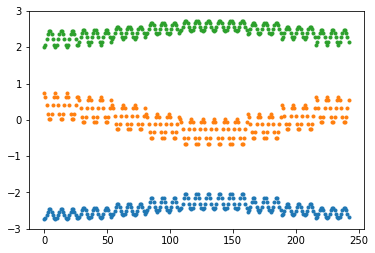

In [20]:
# plot the three bands for q=3
#plt.plot(EEA.flatten(),'.')
plt.plot(EEA[:,:,0].flatten(),'.')
plt.plot(EEA[:,:,1].flatten(),'.')
plt.plot(EEA[:,:,2].flatten(),'.');

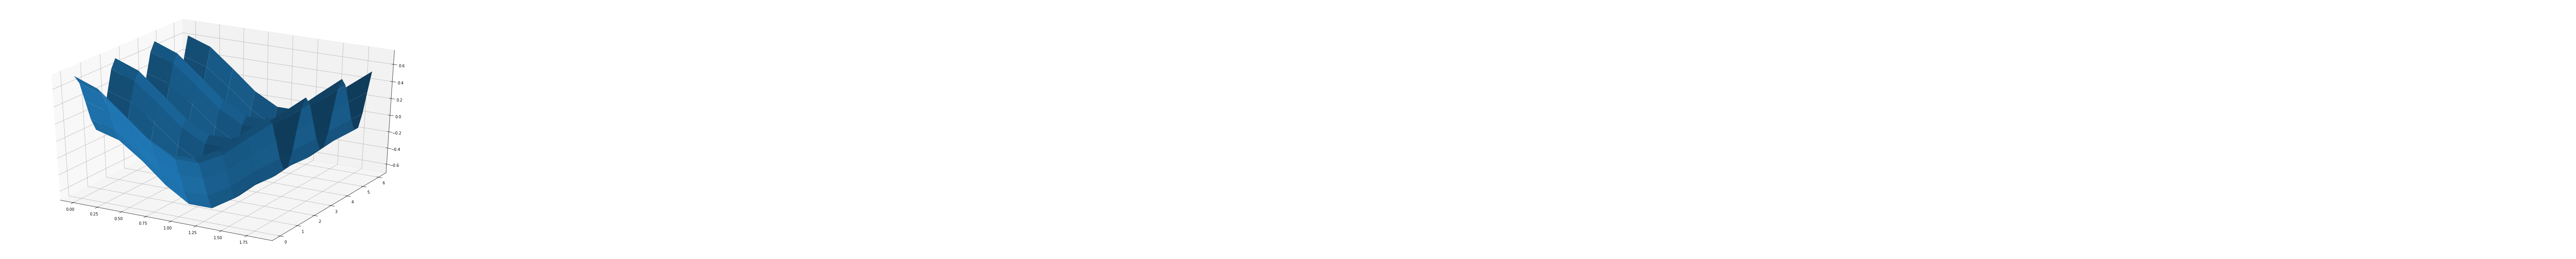

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(20,12))
ax = fig.gca(projection='3d')
#ax.set_aspect('equal')
ax.plot_surface(Mkx,Mky,EEA[:,:,1])

In [22]:
np.dot(np.conj(UUA[1,0,:,1]),UUA[1,0,:,1])
np.mod(Nkx,Nkx)

(0.9999999999999999+0j)

0

In [23]:
bi=1
bj=1
U1=np.zeros([Nkx,Nky],dtype=complex)
U2=np.zeros([Nkx,Nky],dtype=complex)
for ikx,kx in enumerate(kkx):
    for iky,ky in enumerate(kky):
        s1=np.dot(np.conj(UUA[ikx,iky,:,bi]),UUA[np.mod(ikx+1,Nkx),iky,:,bj])
        s2=np.dot(np.conj(UUA[ikx,iky,:,bi]),UUA[ikx,np.mod(iky+1,Nky),:,bj])
        U1[ikx,iky]=s1/np.abs(s1)
        U2[ikx,iky]=s2/np.abs(s2)
        if np.abs(s1)==0:
            print("s1==0",ikx,iky,np.abs(s1))
        if np.abs(s2)==0:
            print("s2=0:",ikx,iky,np.abs(s2))
                
A1=np.log(U1)
A2=np.log(U2)

In [24]:
a=[[1,2,3],[4,5,6],[7,8,9]]
np.roll(a,-1,axis=0)

array([[4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]])

In [29]:
# roll -1 to get the value at k+1

F12=np.log( U1*np.roll(U2,-1,axis=0)*np.conj(np.roll(U1,-1,axis=1)*U2) )

# the expressions below give the same results

#for ikx,kx in enumerate(kkx):
#    for iky,ky in enumerate(kky):
#        F12[ikx,iky] = U1[ikx,iky]*U2[np.mod(ikx+1,Nkx),iky]/(U1[ikx,np.mod(iky+1,Nky)]*U2[ikx,iky])
#        F12[ikx,iky] = np.log(F12[ikx,iky])

#F12=np.log( U1*np.roll(U2,-1,axis=0)/(np.roll(U1,-1,axis=1)*U2) )
        
        
n12=( F12 - np.roll(A2,-1,axis=0)+A2 + np.roll(A1,-1,axis=1)-A1 )/(2j*np.pi)

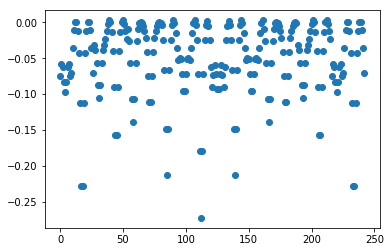

In [30]:
fig = plt.figure()
plt.plot(np.real(F12.flatten()/1j),'o')

In [31]:
#float_formatter = lambda x: "%.0f" % x
#np.set_printoptions(formatter={'float_kind':float_formatter})
with np.printoptions(precision=3, suppress=True):
    print( n12.real )
print("sum n12= ", np.sum(n12)  )
print('sum F12= ',F12.sum()/(2j*np.pi))

[[ 1.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -1.  1.  0.
   0.  0.  0.  1.  0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0.
  -1.  0. -0.  0.  0.  0. -0.  0.  0.]
 [ 0. -0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  1. -0.  0.  0.
   1.  0.  0.  0.  0. -0. -0.  0. -0.]
 [ 0. -1.  0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  1.  0.  0.  0. -1.  1.
   0. -0. -0. -0. -0.  0.  0. -0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -1.
  -1.  0.  0. -0.  0.  0. -0. -0.  0.]
 [-0. -1.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  1.  0.  0.  0. -1.  1.
   0. -0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0. -0. -1.  0.  0. -1.  0.  0. -0.  0.  0.  0. -0. -1.  0.  0.  0. -0.
   1.  0.  0.  0.  0. -0.  0. -0.  0.]
 [-0.  0.  0.  0. -0.  1.  0.  0.  0.  0. -0. -0.  0. -0. -0.  1.  0.  0.
  -1.  0.  0.  0.  0.  0.  0. -0. -0.]
 [ 0. -1.  0. -1.  0.  0. -0.  0.  0.  0.  0. -0. -1.  0.  0. -1.  1.  0.
   0.  0.  0.  1.  0. 

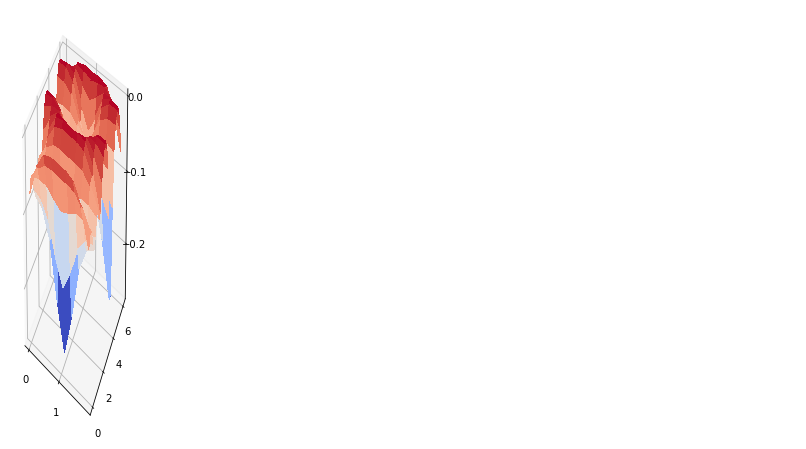

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

X,Y = np.meshgrid(kkx,kky,indexing='ij')

Z=np.real(-1j*F12)

surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


#plt.pcolor(np.real(F12/1j))